In [1]:
import h5py
import itertools
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

from networkx.algorithms import community
from neuropacks import PVC11, NHP, ECOG
from sklearn.neighbors import KernelDensity
from uoineuro.utils import obtain_tuning_preferences
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.coupling_utils import *

%matplotlib inline

In [2]:
base_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling')

# Average Controllability

## Auditory Cortex

In [3]:
# consolidate AC results
ac_results_path = os.path.join(base_path, 'ecog/ecog_coupling.h5')
ac_results = h5py.File(ac_results_path, 'r')
ac_lasso_ccs = np.median(ac_results['lasso/coupling_coefs'], axis=0)
ac_uoi_lasso_ccs = np.median(ac_results['uoi_lasso_bic/coupling_coefs'], axis=0)

In [5]:
G_lasso, _ = create_symmetrized_graph(coupling_coefs=ac_lasso_ccs)
A_lasso = np.array(nx.adjacency_matrix(G_lasso).todense())

G_uoi, _ = create_symmetrized_graph(coupling_coefs=ac_uoi_lasso_ccs)
A_uoi = np.array(nx.adjacency_matrix(G_uoi).todense())

In [6]:
B = np.identity(A_lasso.shape[0])
W_lasso = np.zeros(A_lasso.shape)
W_uoi = np.zeros(A_lasso.shape)
T = 51

uoi_indices = np.zeros(T)
lasso_indices = np.zeros(T)
uoi_traces = np.zeros(T)
lasso_traces = np.zeros(T)

for time in range(T):
    A_lasso_pow = np.linalg.matrix_power(A_lasso, time)
    A_uoi_pow = np.linalg.matrix_power(A_uoi, time)
    
    W_lasso += A_lasso_pow @ B @ A_lasso_pow
    W_uoi += A_uoi_pow @ B @ A_uoi_pow
    
    lasso_eig, _ = np.linalg.eigh(W_lasso)
    uoi_eig, _ = np.linalg.eigh(W_uoi)
    lasso_indices[time] = np.count_nonzero(lasso_eig < 0) / lasso_eig.size
    uoi_indices[time] = np.count_nonzero(uoi_eig < 0) / uoi_eig.size
    
    lasso_traces[time] = np.trace(W_lasso)
    uoi_traces[time] = np.trace(W_uoi)

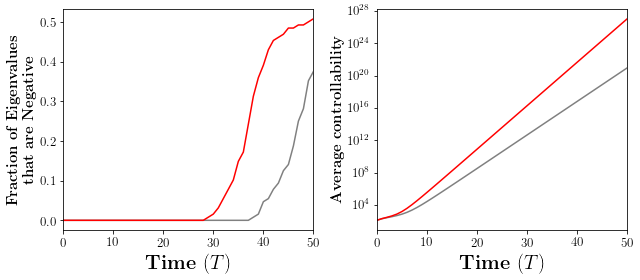

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].plot(np.arange(T), lasso_indices, color='gray')
axes[0].plot(np.arange(T), uoi_indices, color='red')

axes[1].plot(np.arange(T), lasso_traces, color='gray')
axes[1].plot(np.arange(T), uoi_traces, color='r')
axes[1].set_yscale('log')


for ax in axes:
    ax.set_xlim([0, 50])
    ax.set_xlabel(r'\textbf{Time $(T)$}', fontsize=20)
    ax.tick_params(labelsize=13)
    
axes[0].set_ylabel(r'\textbf{Fraction of Eigenvalues}' '\n' r'\textbf{that are Negative}', fontsize=15)
axes[1].set_ylabel(r'\textbf{Average controllability}', fontsize=15)
plt.tight_layout()
plt.savefig('ac_controllability.pdf', bbox_inches='tight')

## Visual Cortex

In [22]:
# consolidate VC results
vc_results_paths = [os.path.join(base_path, 'pvc11/pvc11_monkey1_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey2_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey3_coupling.h5')]
n_vc_fits = len(vc_results_paths)
vc_results = [h5py.File(vc_results_path, 'r')
              for vc_results_path in vc_results_paths]
# extract coupling coefficients
vc_lasso_ccs = [np.median(vc_result['lasso/coupling_coefs'], axis=0)
                for vc_result in vc_results]
vc_uoi_lasso_ccs = [np.median(vc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
                    for vc_result in vc_results]

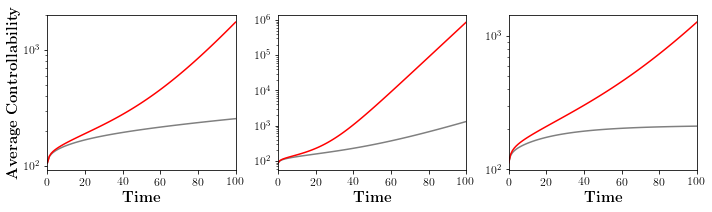

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for idx in range(3):
    G_lasso, _ = create_symmetrized_graph(coupling_coefs=vc_lasso_ccs[idx])
    A_lasso = np.array(nx.adjacency_matrix(G_lasso).todense())

    G_uoi, _ = create_symmetrized_graph(coupling_coefs=vc_uoi_lasso_ccs[idx])
    A_uoi = np.array(nx.adjacency_matrix(G_uoi).todense())

    B = np.identity(A_lasso.shape[0])
    W_lasso = np.zeros(A_lasso.shape)
    W_uoi = np.zeros(A_lasso.shape)
    T = 101

    uoi_traces = np.zeros(T)
    lasso_traces = np.zeros(T)

    for time in range(T):
        A_lasso_pow = np.linalg.matrix_power(A_lasso, time)
        A_uoi_pow = np.linalg.matrix_power(A_uoi, time)

        W_lasso += A_lasso_pow @ B @ A_lasso_pow
        W_uoi += A_uoi_pow @ B @ A_uoi_pow

        lasso_traces[time] = np.trace(W_lasso)
        uoi_traces[time] = np.trace(W_uoi)
        
    axes[idx].plot(np.arange(T), lasso_traces, color='gray')
    axes[idx].plot(np.arange(T), uoi_traces, color='r')
    axes[idx].set_yscale('log')
    axes[idx].set_xlim([0, 100])
    axes[idx].tick_params(labelsize=12)
    axes[idx].set_xlabel(r'\textbf{Time}', fontsize=15)
    
axes[0].set_ylabel(r'\textbf{Average Controllability}', fontsize=15)
    
plt.tight_layout()
plt.savefig('v1_controllability.pdf', bbox_inches='tight')

## Motor Cortex

In [23]:
# consolidate MC results
mc_results_paths = [os.path.join(base_path, 'nhp/nhp_indy_20160407_02_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_01_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_02_coupling.h5')]
n_mc_fits = len(mc_results_paths)
mc_results = [h5py.File(mc_results_path, 'r')
              for mc_results_path in mc_results_paths]
# extract coupling coefficients
mc_lasso_ccs = [np.median(mc_result['lasso/coupling_coefs'], axis=0)
                for mc_result in mc_results]
mc_uoi_lasso_ccs = [np.median(mc_result['uoi_lasso_bic/coupling_coefs'], axis=0)
              for mc_result in mc_results]

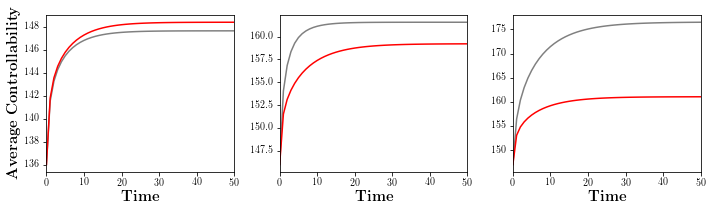

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for idx in range(3):
    G_lasso, _ = create_symmetrized_graph(coupling_coefs=mc_lasso_ccs[idx])
    A_lasso = nx.adjacency_matrix(G_lasso).todense()

    G_uoi, _ = create_symmetrized_graph(coupling_coefs=mc_uoi_lasso_ccs[idx])
    A_uoi = nx.adjacency_matrix(G_uoi).todense()

    B = np.identity(A_lasso.shape[0])
    W_lasso = np.zeros(A_lasso.shape)
    W_uoi = np.zeros(A_lasso.shape)
    T = 51

    uoi_traces = np.zeros(T)
    lasso_traces = np.zeros(T)

    for time in range(T):
        A_lasso_pow = np.linalg.matrix_power(A_lasso, time)
        A_uoi_pow = np.linalg.matrix_power(A_uoi, time)

        W_lasso += A_lasso_pow @ B @ A_lasso_pow
        W_uoi += A_uoi_pow @ B @ A_uoi_pow

        lasso_traces[time] = np.trace(W_lasso)
        uoi_traces[time] = np.trace(W_uoi)
        
    axes[idx].plot(np.arange(T), lasso_traces, color='gray')
    axes[idx].plot(np.arange(T), uoi_traces, color='r')
    axes[idx].set_xlim([0, 50])
    axes[idx].set_xlabel(r'\textbf{Time}', fontsize=15)
    
axes[0].set_ylabel(r'\textbf{Average Controllability}', fontsize=15)

plt.tight_layout()
plt.savefig('m1_controllability.pdf', bbox_inches='tight')

# Modal Controllability

In [58]:
G_lasso, _ = create_symmetrized_graph(coupling_coefs=ac_lasso_ccs)
A_lasso = np.array(nx.adjacency_matrix(G_lasso).todense())

G_uoi, _ = create_symmetrized_graph(coupling_coefs=ac_uoi_lasso_ccs)
A_uoi = np.array(nx.adjacency_matrix(G_uoi).todense())

dd1 = np.sum(A_lasso, axis=1)
dd2 = np.sum(A_uoi, axis=1)

u1, v1 = np.linalg.eigh(A_lasso)
u2, v2 = np.linalg.eigh(A_uoi)

phi1 = np.sum((1 - u1**2) * v1**2, axis=1)
phi2 = np.sum((1 - u2**2) * v2**2, axis=1)

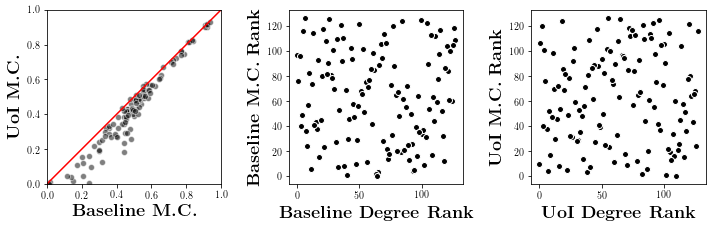

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].scatter(phi1, phi2, color='k', alpha=0.5, edgecolor='white')
axes[1].scatter(np.argsort(dd1), np.argsort(phi1), color='k', edgecolor='white')
axes[2].scatter(np.argsort(dd2), np.argsort(phi2), color='k', edgecolor='white')

axes[0].plot([0, 1], [0, 1], color='red')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[0].set_xlabel(r'\textbf{Baseline M.C.}', fontsize=18)
axes[0].set_ylabel(r'\textbf{UoI M.C.}', fontsize=18)
axes[1].set_xlabel(r'\textbf{Baseline Degree Rank}', fontsize=18)
axes[1].set_ylabel(r'\textbf{Baseline M.C. Rank}', fontsize=18)
axes[2].set_xlabel(r'\textbf{UoI Degree Rank}', fontsize=18)
axes[2].set_ylabel(r'\textbf{UoI M.C. Rank}', fontsize=18)
for ax in axes:
    ax.set_aspect('equal')
plt.tight_layout()

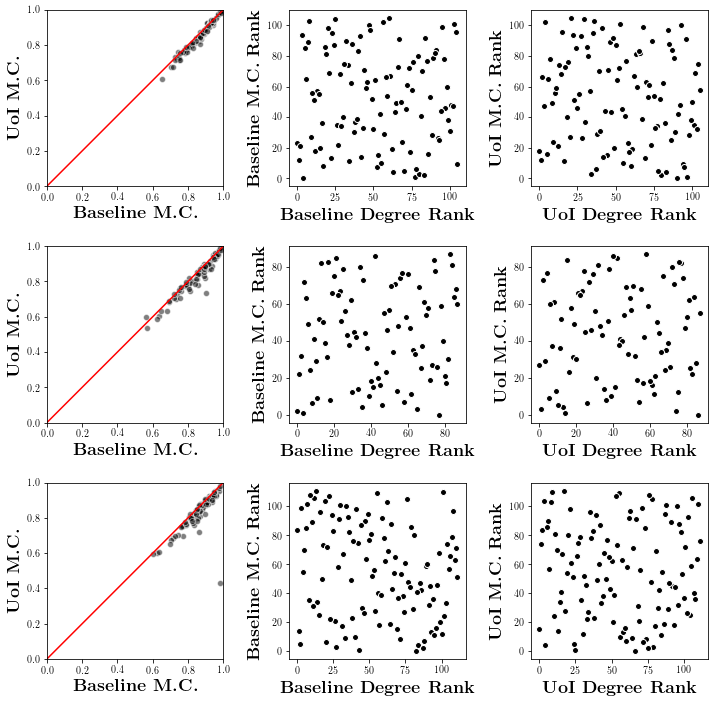

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx in range(3):
    G_lasso, _ = create_symmetrized_graph(coupling_coefs=vc_lasso_ccs[idx])
    A_lasso = np.array(nx.adjacency_matrix(G_lasso).todense())

    G_uoi, _ = create_symmetrized_graph(coupling_coefs=vc_uoi_lasso_ccs[idx])
    A_uoi = np.array(nx.adjacency_matrix(G_uoi).todense())

    u1, v1 = np.linalg.eigh(A_lasso)
    u2, v2 = np.linalg.eigh(A_uoi)
    
    phi1 = np.sum((1 - u1**2) * v1**2, axis=1)
    phi2 = np.sum((1 - u2**2) * v2**2, axis=1)
    
    dd1 = np.sum(A_lasso, axis=1)
    dd2 = np.sum(A_uoi, axis=1)
    
    axes[idx, 0].scatter(phi1, phi2, color='k', alpha=0.5, edgecolor='white')
    axes[idx, 1].scatter(np.argsort(dd1), np.argsort(phi1), color='k', edgecolor='white')
    axes[idx, 2].scatter(np.argsort(dd2), np.argsort(phi2), color='k', edgecolor='white')

    axes[idx, 0].plot([0, 1], [0, 1], color='red')
    axes[idx, 0].set_xlim([0, 1])
    axes[idx, 0].set_ylim([0, 1])

    axes[idx, 0].set_xlabel(r'\textbf{Baseline M.C.}', fontsize=18)
    axes[idx, 0].set_ylabel(r'\textbf{UoI M.C.}', fontsize=18)
    axes[idx, 1].set_xlabel(r'\textbf{Baseline Degree Rank}', fontsize=18)
    axes[idx, 1].set_ylabel(r'\textbf{Baseline M.C. Rank}', fontsize=18)
    axes[idx, 2].set_xlabel(r'\textbf{UoI Degree Rank}', fontsize=18)
    axes[idx, 2].set_ylabel(r'\textbf{UoI M.C. Rank}', fontsize=18)
    
for ax in axes.ravel():
    ax.set_aspect('equal')
    
plt.tight_layout()

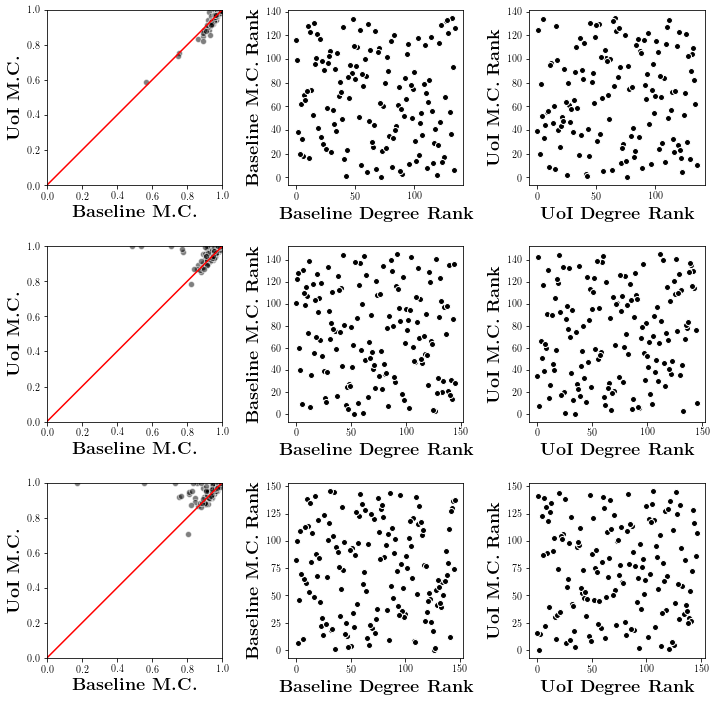

In [68]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx in range(3):
    G_lasso, _ = create_symmetrized_graph(coupling_coefs=mc_lasso_ccs[idx])
    A_lasso = np.array(nx.adjacency_matrix(G_lasso).todense())

    G_uoi, _ = create_symmetrized_graph(coupling_coefs=mc_uoi_lasso_ccs[idx])
    A_uoi = np.array(nx.adjacency_matrix(G_uoi).todense())

    u1, v1 = np.linalg.eigh(A_lasso)
    u2, v2 = np.linalg.eigh(A_uoi)
    
    phi1 = np.sum((1 - u1**2) * v1**2, axis=1)
    phi2 = np.sum((1 - u2**2) * v2**2, axis=1)
    
    dd1 = np.sum(A_lasso, axis=1)
    dd2 = np.sum(A_uoi, axis=1)
    
    axes[idx, 0].scatter(phi1, phi2, color='k', alpha=0.5, edgecolor='white')
    axes[idx, 1].scatter(np.argsort(dd1), np.argsort(phi1), color='k', edgecolor='white')
    axes[idx, 2].scatter(np.argsort(dd2), np.argsort(phi2), color='k', edgecolor='white')

    axes[idx, 0].plot([0, 1], [0, 1], color='red')
    axes[idx, 0].set_xlim([0, 1])
    axes[idx, 0].set_ylim([0, 1])

    axes[idx, 0].set_xlabel(r'\textbf{Baseline M.C.}', fontsize=18)
    axes[idx, 0].set_ylabel(r'\textbf{UoI M.C.}', fontsize=18)
    axes[idx, 1].set_xlabel(r'\textbf{Baseline Degree Rank}', fontsize=18)
    axes[idx, 1].set_ylabel(r'\textbf{Baseline M.C. Rank}', fontsize=18)
    axes[idx, 2].set_xlabel(r'\textbf{UoI Degree Rank}', fontsize=18)
    axes[idx, 2].set_ylabel(r'\textbf{UoI M.C. Rank}', fontsize=18)
    
for ax in axes.ravel():
    ax.set_aspect('equal')
    
plt.tight_layout()